<a href="https://colab.research.google.com/github/zyang63/Die_casting_ejection/blob/main/draft_angle_marking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
%%capture
!pip install trimesh
!pip install bpy
!pip install numpy tripy
!pip install numpy pillow

In [ ]:
import os
import bpy
import math
import numpy as np
from PIL import Image, ImageDraw
import trimesh as t
from trimesh.voxel import creation

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from google.colab import files
#@title #File Entry { display-mode: "form"}
#@markdown User can choose to upload the file to colab directly or select the google file upload button at the bottom of this form. Also choose the number of elements.

button_pressed = False  # Initialize the variable as False
filename = ""
button = widgets.Button(description="Google upload dialog")
output = widgets.Output()

def on_button_clicked(b):
    global button_pressed  # Access the global variable
    global filename
    with output:
        uploaded = files.upload()
        filename = list(uploaded.keys())[0]
        button_pressed = True  # Set the variable to True when the button is clicked

button.on_click(on_button_clicked)
display(button, output)

Button(description='Google upload dialog', style=ButtonStyle())

Output()

In [ ]:
#@title #Element Count { display-mode: "form", run: "auto" }
element_count = 177 #@param {type:"slider", min:10, max:500, step:1}
if not button_pressed:
  filename = "/content/Casting_Shot - 8M0111257-1.STL" #@param {type:"string"}
geometry = t.load_mesh(filename)
#geometry = t.load_mesh("/content/ball.stl")
voxel_size = geometry.extents.max()/element_count
print("Element size is in units from stl file ",voxel_size, " per cell")

Element size is in units from stl file  1.0004430005779374  per cell


#Direction

select direction here

In [13]:
# Define the choose_axis function
def choose_axis(axis):
    axis_vectors = {
        'x': [0.0, 0.0, 1.0],

        'y': [1.0, 0.0, 0.0] ,

        'z': [0.0, 1.0, 0.0]

    }
    return axis_vectors.get(axis, None)

# Create a dropdown widget for axis selection
axis_dropdown = widgets.Dropdown(
    options=['x', 'y', 'z'],
    description='Select Axis:',
    disabled=False,
)

# Output widget for displaying the result
output_widget = widgets.Output()

# Define a function to update the output and export data
selected_axis_data = None
def update_axis(selected_axis):
    with output_widget:
        output_widget.clear_output()  # Clear previous output
        axis_vector = choose_axis(selected_axis)
        if axis_vector is not None:
            print(f"Selected Axis {selected_axis}: {axis_vector}")
            global selected_axis_data
            selected_axis_data = axis_vector

# Link the widget to the update function
widgets.interactive(update_axis, selected_axis=axis_dropdown)

# Display the dropdown widget and the output widget
display(axis_dropdown)

Dropdown(description='Select Axis:', options=('x', 'y', 'z'), value='x')

# Remesh and output OBJ file

In [23]:
!apt-get install blender

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  blender-data fonts-dejavu fonts-dejavu-core fonts-dejavu-extra libdcmtk16 libembree3-3
  libfftw3-double3 libjemalloc2 liblog4cplus-2.0.5 libopencolorio1v5 libopenimageio2.2
  libopenvdb8.1 libosdcpu3.4.4 libpugixml1v5 libraw20 libspnav0 libsquish0 libtinyxml2.6.2v5
  libwrap0 libyaml-cpp0.7
Suggested packages:
  libfftw3-bin libfftw3-dev spacenavd
The following NEW packages will be installed:
  blender blender-data fonts-dejavu fonts-dejavu-core fonts-dejavu-extra libdcmtk16 libembree3-3
  libfftw3-double3 libjemalloc2 liblog4cplus-2.0.5 libopencolorio1v5 libopenimageio2.2
  libopenvdb8.1 libosdcpu3.4.4 libpugixml1v5 libraw20 libspnav0 libsquish0 libtinyxml2.6.2v5
  libwrap0 libyaml-cpp0.7
0 upgraded, 21 newly installed, 0 to remove and 9 not upgraded.
Need to get 115 MB of archives.
After this operation, 705 MB of additional disk spac

In [28]:
blender_script = f"""
import bpy

bpy.ops.wm.read_factory_settings(use_empty=True)

# Import STL mesh and apply remesh modifier
bpy.ops.import_mesh.stl(filepath= "{filename}", global_scale=0.1,)

bpy.ops.object.modifier_add(type='REMESH')
bpy.context.object.modifiers["Remesh"].mode = 'VOXEL'
bpy.context.object.modifiers["Remesh"].voxel_size = {voxel_size}/10
bpy.ops.object.modifier_apply(modifier="Remesh")

# Unwrap the mesh using Smart UV Project
bpy.ops.object.mode_set(mode='EDIT')
bpy.ops.mesh.select_all(action='SELECT')
bpy.ops.uv.smart_project()
bpy.ops.object.mode_set(mode='OBJECT')
selected_object = bpy.context.object



# Export the object as an OBJ file
for obj in bpy.context.selected_objects:
    if obj.type == "MESH":
        bpy.ops.export_scene.obj(filepath="/content/remeshed_uv.obj", use_triangles=False, use_materials=False)

file_path = "/content/meshed_geometry.blend"
# Save the file
bpy.ops.wm.save_as_mainfile(filepath=file_path)"""
script_filename = "/content/blender_script.py"
with open(script_filename, "w") as script_file:
    script_file.write(blender_script)

# Run Blender in headless mode with the script
!blender -b -P {script_filename}

Color management: using fallback mode for management
Color management: Error could not find role data role.
Blender 3.0.1
Color management: scene view "Filmic" not found, setting default "Standard".
Color management: scene view "Filmic" not found, setting default "Standard".
Import finished in 0.9167 sec.
    (  0.0002 sec |   0.0000 sec) OBJ Export path: '/content/remeshed_uv.obj'
          (  5.8953 sec |   5.8950 sec) Finished writing geometry of 'Casting_Shot - 8M0111257-1'.
      (  5.8954 sec |   5.8952 sec) Finished exporting geometry, now exporting materials
      (  5.8955 sec |   5.8952 sec) OBJ Export Finished
Progress: 100.00%

Info: Total files 0 | Changed 0 | Failed 0
Info: Saved "meshed_geometry.blend"
Info: Saved "meshed_geometry.blend"

Blender quit


# cosine calculated

In [40]:
# Replace 'your_obj_file.obj' with the actual file path.
obj_file_path = '/content/remeshed_uv.obj'

# Initialize lists to store vertices, faces, cosines, and VT coordinates.
vertices = []
faces = []
cosines = []
vt_coordinates = []
vt_faces = []
F_list = []
tangents = []
# Read the OBJ file and extract vertices, faces, cosines, and VT coordinates.
with open(obj_file_path, 'r') as obj_file:
    for line in obj_file:
        if line.startswith('v '):
            vertex = list(map(float, line.split()[1:]))
            if len(vertex) == 2:  # Check for 2D vertices and add a 'z' component
                vertex.append(0.0)
            vertices.append(vertex)
        elif line.startswith('f '):
            elements = line.split()[1:]
            face = []
            vt_face = []
            for element in elements:
                vertex_indices = element.split('/')
                v_index = int(vertex_indices[0]) - 1  # Vertex index
                vt_index = int(vertex_indices[1]) - 1  # Vertex index
                face.append(v_index)
                vt_face.append(vt_index)
            faces.append(face)
            vt_faces.append(vt_face)
            #print(vt_face)
        elif line.startswith('vt '):
            vt = list(map(float, line.split()[1:]))
            vt_coordinates.append(vt)
# Calculate normal vectors for each face.
normal_vectors = []
for face in faces:
    if all(0 <= i < len(vertices) for i in face):  # Check that all vertex indices are valid.
        v0 = np.array(vertices[face[0]])
        v1 = np.array(vertices[face[1]])
        v2 = np.array(vertices[face[2]])

        edge1 = v1 - v0
        edge2 = v2 - v0

        normal = np.cross(edge1, edge2)
        normal /= np.linalg.norm(normal)
        normal_vectors.append(normal)

        direction = np.array(selected_axis_data)
        dot_product = np.dot(normal, direction)

        # Calculate the Euclidean norms of A and B
        norm_A = np.linalg.norm(normal)
        norm_B = np.linalg.norm(direction)

        # Calculate the cosine similarity
        cosine = dot_product / (norm_A * norm_B)
        sine = np.sqrt(1 - cosine**2)
        F = 0.6*abs(cosine) - abs(sine)
        tangent =  abs(sine) / abs(cosine)
        F_list.append(F)
        cosines.append(cosine)
        tangents.append(tangent)

<ipython-input-40-3008f4cff3f1>:62: RuntimeWarning: divide by zero encountered in double_scalars
  tangent =  abs(sine) / abs(cosine)


In [41]:
cosines_array = np.array(cosines)
F_array = np.array(F_list)
max_F = F_array.max()
min_F = F_array.min()
tangents_array = np.array(tangents)
tangent_filtered_array = tangents_array[~np.isnan(tangents_array) & np.isfinite(tangents_array)]
max_tangent = tangent_filtered_array.max()
min_tangent = tangent_filtered_array.min()
print(max_tangent)
print(min_tangent)

77072.97257969812
0.0


# Texture marked

In [31]:
# Determine the image size.
image_size = 1080

color_bins = [(i, 0, 256-i) for i in range(0, 256, 26)]

# Create a black image.
image = Image.new("RGB", (image_size, image_size), "black")
draw = ImageDraw.Draw(image)

# Scale the VT coordinates to fit the 1080x1080 image size.
scaled_vt_coordinates = [
    (vt[0] * image_size, (1 - vt[1]) * image_size) for vt in vt_coordinates
]

# Loop through the faces and apply red or blue coloring based on cosines.
for i, (vt_face, F) in enumerate(zip(vt_faces, F_list)):
    if all(0 <= j < len(scaled_vt_coordinates) for j in vt_face):
        vt_indices = [scaled_vt_coordinates[j] for j in vt_face]
        #print(vt_indices)
        fraction = (F - min_F) / (max_F - min_F)
        index = int(fraction * 10)
        index = max(0, min(index, 9))  # Ensure the index is within the valid range

    # Use the selected color from the color_bins list
        color = color_bins[index]
        draw.polygon(
            vt_indices,
            outline=color,
            fill=color,
        )

# Save the marked image.
image.save('marked_image_F.png')


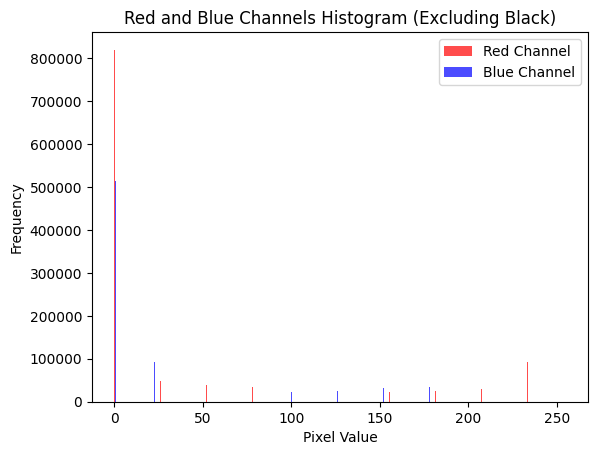

In [57]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = "/content/marked_image_F.png"  # Replace with the actual path to your image
image = cv2.imread(image_path)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Extract the red and blue channels
red_channel = image_rgb[:, :, 0]
blue_channel = image_rgb[:, :, 2]

# Plot the combined histogram
plt.hist([red_channel.ravel(), blue_channel.ravel()], bins=256, color=['red', 'blue'], alpha=0.7, rwidth=0.8, label=['Red Channel', 'Blue Channel'])
plt.title('Red and Blue Channels Histogram (Excluding Black)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [42]:
max_tangent = -float('inf')  # Initialize max_tangent to negative infinity
for i, (vt_face, cosine, tangent) in enumerate(zip(vt_faces, cosines, tangents)):
    if all(0 <= j < len(scaled_vt_coordinates) for j in vt_face):
        vt_indices = [scaled_vt_coordinates[j] for j in vt_face]

        if tangent != float('inf'):
            if tangent > max_tangent:
                max_tangent = tangent

In [45]:
# Determine the image size.
image_size = 1080

color_bins = [(i, 0, 256-i) for i in range(0, 256, 26)]

# Create a black image.
image = Image.new("RGB", (image_size, image_size), "black")
draw = ImageDraw.Draw(image)

# Scale the VT coordinates to fit the 1080x1080 image size.
scaled_vt_coordinates = [
    (vt[0] * image_size, (1 - vt[1]) * image_size) for vt in vt_coordinates
]

# Loop through the faces and apply red or blue coloring based on cosines.
for i, (vt_face,cosine, tangent) in enumerate(zip(vt_faces, cosines ,tangents)):
    if all(0 <= j < len(scaled_vt_coordinates) for j in vt_face):
        vt_indices = [scaled_vt_coordinates[j] for j in vt_face]
        if tangent != float('inf'):
          fraction = (tangent - min_tangent) / (max_tangent - min_tangent)

    # Map fraction to one of the 10 color bins
          index = int(fraction * 10)
          index = max(0, min(index, 9))  # Ensure the index is within the valid range

    # Use the selected color from the color_bins list
          color = color_bins[index]
        else:
            color = (255, 255, 255)
        # Draw a red or blue polygon on the image.
        draw.polygon(
            vt_indices,
            outline=color,
            fill=color,
        )

# Save the marked image.
image.save('marked_image_line.png')

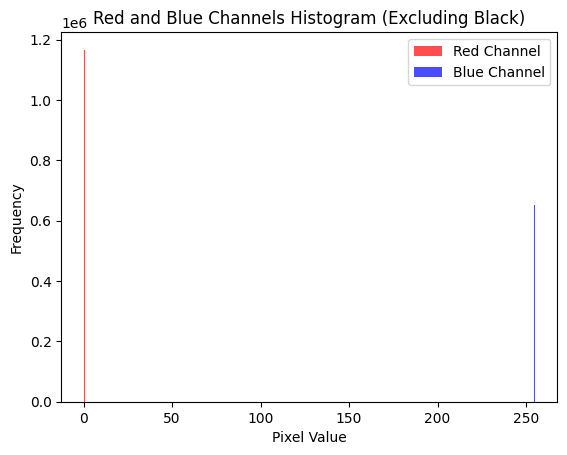

In [56]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = "/content/marked_image_line.png"  # Replace with the actual path to your image
image = cv2.imread(image_path)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Extract the red and blue channels
red_channel = image_rgb[:, :, 0]
blue_channel = image_rgb[:, :, 2]


# Plot the combined histogram
plt.hist([red_channel.ravel(), blue_channel.ravel()], bins=256, color=['red', 'blue'], alpha=0.7, rwidth=0.8, label=['Red Channel', 'Blue Channel'])
plt.title('Red and Blue Channels Histogram (Excluding Black)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Visualization

In [ ]:
bpy.ops.wm.open_mainfile(filepath=file_path)
material = bpy.data.materials.new(name="MyMaterial")

# Create a new shader node tree for the material
material.use_nodes = True
tree = material.node_tree
nodes = tree.nodes

# Clear existing nodes
for node in nodes:
    nodes.remove(node)

# Create a new Principled BSDF node
bsdf_node = nodes.new(type='ShaderNodeBsdfPrincipled')
bsdf_node.location = (0, 0)  # Position the node in the node editor

# Create a new Image Texture node
texture_node = nodes.new(type='ShaderNodeTexImage')
texture_node.location = (-200, 0)  # Position the node in the node editor

# Set the path to the image texture
texture_node.image = bpy.data.images.load("/content/marked_image_F.png")

# Connect the Image Texture node to the Base Color input of the Principled BSDF node
base_color_link = tree.links.new(texture_node.outputs['Color'], bsdf_node.inputs['Base Color'])

# Create a new Material Output node
output_node = nodes.new(type='ShaderNodeOutputMaterial')
output_node.location = (200, 0)  # Position the node in the node editor

# Connect the Principled BSDF node to the Surface input of the Material Output node
surface_link = tree.links.new(bsdf_node.outputs['BSDF'], output_node.inputs['Surface'])

# Assign the material to the active object
bpy.context.object.data.materials.append(material)
bpy.ops.export_scene.gltf(filepath="/content/colored_F_geometry.glb")

03:25:24 | ERROR: Draco mesh compression is not available because library could not be found at /content/3.6/python/lib/python3.10/site-packages/libextern_draco.so
03:25:24 | INFO: Starting glTF 2.0 export
03:25:24 | INFO: Extracting primitive: Casting_Shot - 8M0111257-1
03:25:26 | INFO: Primitives created: 1
03:25:26 | INFO: Finished glTF 2.0 export in 2.121504783630371 s



{'FINISHED'}

In [ ]:
bpy.ops.wm.open_mainfile(filepath=file_path)
material = bpy.data.materials.new(name="MyMaterial")

# Create a new shader node tree for the material
material.use_nodes = True
tree = material.node_tree
nodes = tree.nodes

# Clear existing nodes
for node in nodes:
    nodes.remove(node)

# Create a new Principled BSDF node
bsdf_node = nodes.new(type='ShaderNodeBsdfPrincipled')
bsdf_node.location = (0, 0)  # Position the node in the node editor

# Create a new Image Texture node
texture_node = nodes.new(type='ShaderNodeTexImage')
texture_node.location = (-200, 0)  # Position the node in the node editor

# Set the path to the image texture
texture_node.image = bpy.data.images.load("/content/marked_image_line.png")

# Connect the Image Texture node to the Base Color input of the Principled BSDF node
base_color_link = tree.links.new(texture_node.outputs['Color'], bsdf_node.inputs['Base Color'])

# Create a new Material Output node
output_node = nodes.new(type='ShaderNodeOutputMaterial')
output_node.location = (200, 0)  # Position the node in the node editor

# Connect the Principled BSDF node to the Surface input of the Material Output node
surface_link = tree.links.new(bsdf_node.outputs['BSDF'], output_node.inputs['Surface'])

# Assign the material to the active object
bpy.context.object.data.materials.append(material)
bpy.ops.export_scene.gltf(filepath="/content/colored_line_geometry.glb")

03:30:03 | ERROR: Draco mesh compression is not available because library could not be found at /content/3.6/python/lib/python3.10/site-packages/libextern_draco.so
03:30:03 | INFO: Starting glTF 2.0 export
03:30:03 | INFO: Extracting primitive: Casting_Shot - 8M0111257-1
03:30:06 | INFO: Primitives created: 1
03:30:06 | INFO: Finished glTF 2.0 export in 2.5856149196624756 s



{'FINISHED'}

In [ ]:
files_to_delete = [
    "/content/meshed_geometry.blend",
    "/content/remeshed_uv.obj",
    "/content/marked_image_F.png",
    "/content/marked_image_line.png"
]

for file_path in files_to_delete:
    if os.path.exists(file_path):
        os.remove(file_path)